<a href="https://colab.research.google.com/github/philusdevs/Plant_Disease_Prediction/blob/main/Plant_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

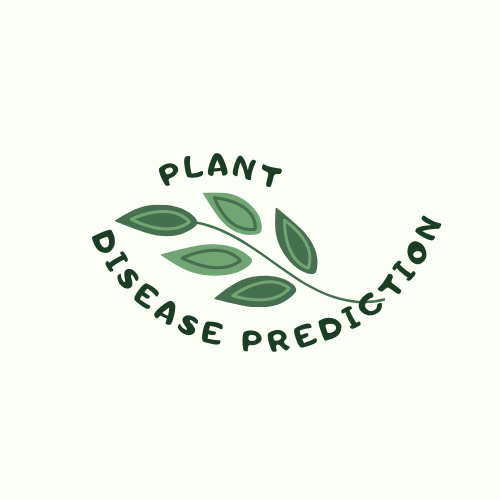

This project uses a Convolutional Neural Network to predict whether a crop is suffering from a disease. The project also uses different layers and other hyperparameters for building, training and testing the classifictaion model. Modeling will be done using tensorflow and keras.

First we will mount our google drive on colab so that we can use the dataset directly from our drive.

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


After mounting our drive we will locate the folder where our data is stored to use it in our colab notebook.


In [ ]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive/data/Plant_images".
!ls "/content/drive/My Drive/data/Plant_images"

'Corn_(maize)___Common_rust_'   Potato___Early_blight   Tomato___Bacterial_spot


Next we will import all the required libraries.  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.optimizers import adam_v2
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from tensorflow.keras.utils import to_categorical

Now we will observe some of the images that are their in our dataset. We will plot 12 images here using the matplotlib library.

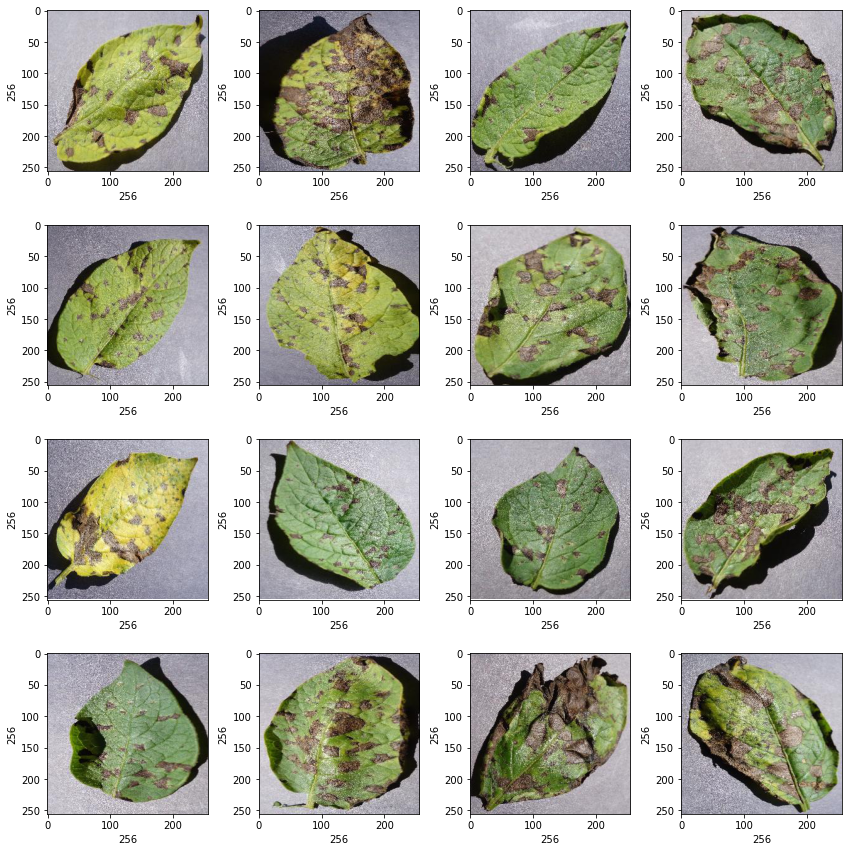

In [ ]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
path = "/content/drive/My Drive/data/Plant_images/Potato___Early_blight"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

After visualizing the images, a function will be created that will convert the images into a numpy array to normalise the dataset.

In [ ]:
#Converting Images to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (256,256))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [ ]:
dir = "/content/drive/My Drive/data/Plant_images"
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['Corn-Common_rust', 'Potato-Early_blight', 'Tomato-Bacterial_spot']
binary_labels = [0,1,2]
temp = -1

# Reading and converting image to numpy array
for directory in root_dir:
  plant_image_list = listdir(f"{dir}/{directory}")
  temp += 1
  for files in plant_image_list:
    image_path = f"{dir}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(binary_labels[temp])

We will also observe the number of images under different classes to see if the dataset is normalise

In [ ]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

0    320
1    300
2    300
dtype: int64

Next we will observe the shape of the image.

In [ ]:
image_list[0].shape

(256, 256, 3)

Checking the total number of the images which is the length of the labels list.

In [ ]:
label_list = np.array(label_list)
label_list.shape

(920,)

Next we will use sklearn train_test_split to split the dataset into testing and training data. Here I have taken test size as 0.2 so my data will be divided into 80% training and 20% testing data.

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10)

Now we will normalize the dataset of our images. As pixel values ranges from 0 to 255 so we will divide each image pixel with 255 to normalise the dataset.

In [ ]:
x_train = np.array(x_train, dtype=np.float16) / 225.0
x_test = np.array(x_test, dtype=np.float16) / 225.0
x_train = x_train.reshape( -1, 256,256,3)
x_test = x_test.reshape( -1, 256,256,3)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Next a network architecture is created for the model. We have used different types of layers according to their features namely Conv_2d (It is used to create a convolutional kernel that is convolved with the input layer to produce the output tensor), max_pooling2d (It is a downsampling technique which takes out the maximum value over the window defined by poolsize), flatten (It flattens the input and creates a 1D output), Dense (Dense layer produce the output as the dot product of input and kernel).


In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(256,256,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 28224)             0         
                                                                 
 dense (Dense)               (None, 8)                 2

While compiling the model we need to set the type of loss which will be Categorical Crossentropy for our model alongwith this we also need to set the optimizer and the metrics respectively.

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

Next we will split the dataset into validation and training data.

In [ ]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

Fitting the model with the data and finding out the accuracy at each epoch to see how our model is learning. Increasing the number of epochs also increases the accuracy however here we can see that the model has already raeched a very high accuracy so we do not need to rerun it.

In [ ]:
# Training the model
epochs = 50
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (x_val, y_val))

Epoch 1/50
5/5 [==============================] - 14s 403ms/step - loss: 1.0374 - accuracy: 0.5782 - val_loss: 0.9598 - val_accuracy: 0.6284
Epoch 2/50
5/5 [==============================] - 1s 165ms/step - loss: 0.8970 - accuracy: 0.6463 - val_loss: 0.8213 - val_accuracy: 0.7297
Epoch 3/50
5/5 [==============================] - 1s 165ms/step - loss: 0.7925 - accuracy: 0.7976 - val_loss: 0.7413 - val_accuracy: 0.7838
Epoch 4/50
5/5 [==============================] - 1s 163ms/step - loss: 0.6950 - accuracy: 0.8554 - val_loss: 0.6690 - val_accuracy: 0.8851
Epoch 5/50
5/5 [==============================] - 1s 168ms/step - loss: 0.6169 - accuracy: 0.9286 - val_loss: 0.5890 - val_accuracy: 0.8919
Epoch 6/50
5/5 [==============================] - 1s 165ms/step - loss: 0.5514 - accuracy: 0.9218 - val_loss: 0.5753 - val_accuracy: 0.8784
Epoch 7/50
5/5 [==============================] - 1s 165ms/step - loss: 0.4973 - accuracy: 0.9405 - val_loss: 0.5023 - val_accuracy: 0.9122
Epoch 8/50
5/5 [===

Save the model to google drive.

In [ ]:
model.save("/content/drive/My Drive/data/plant_disease.h5")
# saving serialize model to json
json_model = model.to_json()
# saving the model architecture to JSON file
with open('/content/drive/My Drive/data/plant_model.json', 'w') as json_file:
    json_file.write(json_model)
#saving the weights of the model
model.save_weights('/content/drive/My Drive/data/plant_model_weights.h5')

Next we will plot the accuracy of the model for the trainig history.

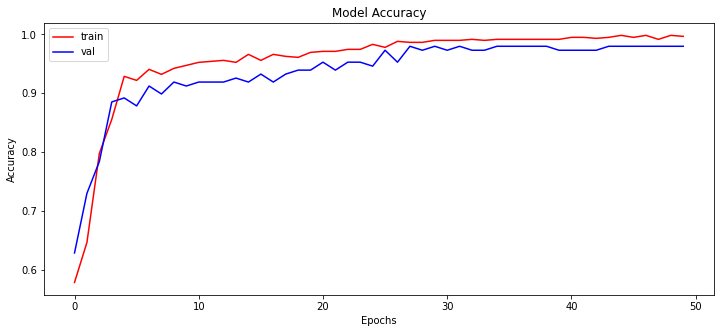

In [ ]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

Evaluating the model to know the accuracy of the model.


In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
6/6 [==============================] - 0s 43ms/step - loss: 0.0696 - accuracy: 0.9728
Test Accuracy: 97.28260636329651


In [ ]:
y_pred = model.predict(x_test)

Next we will use the model to predict the testing dataset label.

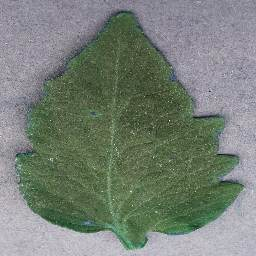

In [ ]:
# Plotting image to compare
img = array_to_img(x_test[13])
img

Printing out the original and the predicted label.

In [ ]:
# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",all_labels[np.argmax(y_test[10])])
print("Predicted : ",all_labels[np.argmax(y_pred[10])])

Originally :  Corn-Common_rust
Predicted :  Corn-Common_rust
